# Results

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
path = 'logs/results/14-10-2021-09:14:21.json'
main_metric = 'pr_auc'
dataframe = pd.read_json(path)
dataframe.head()

,dataset,keep_dropped,features_up_to_round,round_to_predict,model,metric,score,feature_importance,best_parameters,details
0,cs1-s,False,1,2,LogisticRegression,pr_auc,0.736,"{'importance': {'18': 0.9280014910000001, '28'...","{'cls__C': 0.001, 'fsl__k': 'max', 'fsl__metho...","{'fit_time': [0.6387012005, 0.6787109375, 0.61..."
1,cs1-s,False,1,2,LogisticRegression,roc_auc,0.949,"{'importance': {'18': 0.9280014910000001, '28'...","{'cls__C': 0.001, 'fsl__k': 'max', 'fsl__metho...","{'fit_time': [0.6387012005, 0.6787109375, 0.61..."
2,cs1-s,False,1,2,LogisticRegression,f1,0.763,"{'importance': {'18': 0.9280014910000001, '28'...","{'cls__C': 0.001, 'fsl__k': 'max', 'fsl__metho...","{'fit_time': [0.6387012005, 0.6787109375, 0.61..."
3,cs1-s,False,1,2,LogisticRegression,f1-beta,0.763,"{'importance': {'18': 0.9280014910000001, '28'...","{'cls__C': 0.001, 'fsl__k': 'max', 'fsl__metho...","{'fit_time': [0.6387012005, 0.6787109375, 0.61..."
4,cs1-s,False,1,2,LogisticRegression,f2,0.855,"{'importance': {'18': 0.9280014910000001, '28'...","{'cls__C': 0.001, 'fsl__k': 'max', 'fsl__metho...","{'fit_time': [0.6387012005, 0.6787109375, 0.61..."


In [3]:
dataframe["approach"] = ["Excluding" if not kd else "Including" for kd in dataframe["keep_dropped"]]
to_remove = ["details", "best_parameters", "feature_importance", "keep_dropped"]
to_remove = [t for t in to_remove if t in dataframe]
results = dataframe.drop(to_remove, axis=1)

In [4]:
from postprocess import Cols, Datasets, Models, metric_map, update_result_labels
results = update_result_labels(results)

### Comparing the previous and the proposed approach in terms of performance obtained

wrote dataset-by-metric-predicting-round-7-rf-mv-distinct.pdf
wrote dataset-by-metric-predicting-round-7-rf-mv-distinct.svg


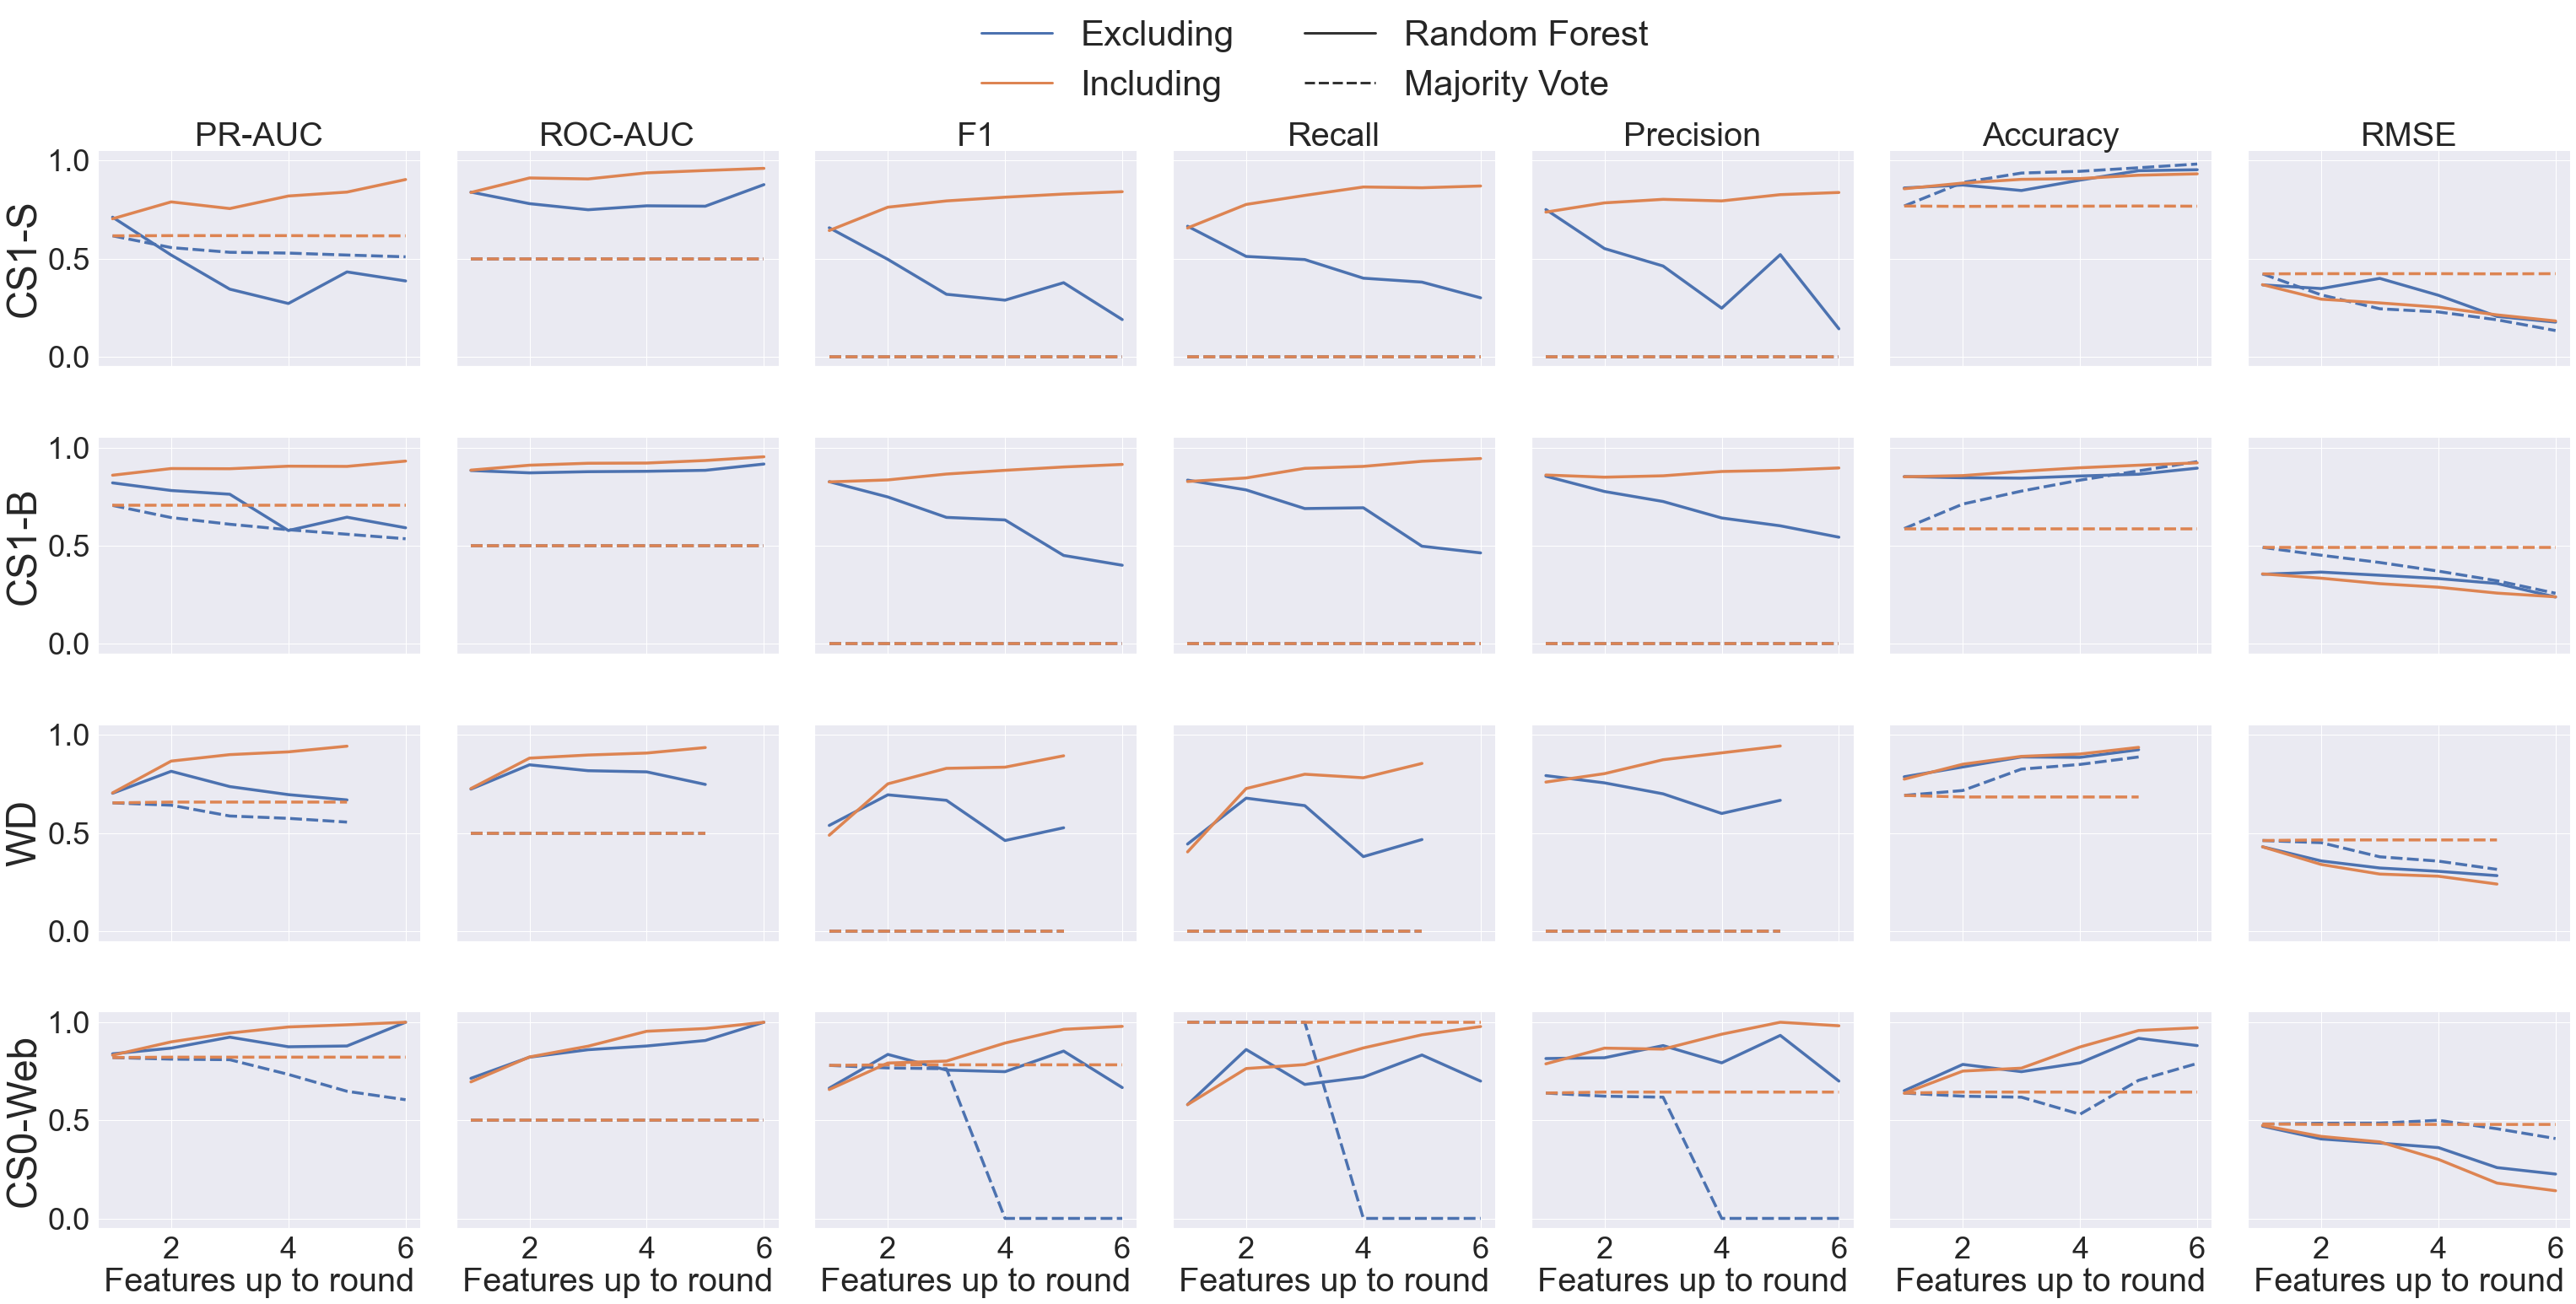

In [5]:
models = (Models.rf, Models.mv)
models = ','.join([f'"{m}"' for m in models])
metrics = ["acc", "roc_auc", "precision", "recall", "f1", "pr_auc", "rmse"] 
metrics = ','.join([f'"{metric_map[m]}"' for m in metrics])

df = results.query(f'{Cols.metric} in ({metrics})') \
            .query(f'(`{Cols.round_to_predict}` == 7 and {Cols.dataset} != "{Datasets.wd}") or (`{Cols.round_to_predict}` == 6 and {Cols.dataset} == "{Datasets.wd}")') \
            .query(f'{Cols.model} in ({models})')

sns.set(font_scale=3.3)
g = sns.relplot(data=df, row=Cols.dataset, col=Cols.metric, y=Cols.score, x =Cols.features_up_to_round, 
                style=Cols.model, hue=Cols.approach, kind="line", linewidth=3.5, aspect=11/9)
g.set_titles(template='')

colnames = df[Cols.metric].unique()
for ax, col in zip(g.axes[0], colnames):
    ax.set_title(col)

g.set_axis_labels(y_var='')
rownames = df[Cols.dataset].unique()
for ax, row in zip(g.axes[:,0], rownames):
    ax.set_ylabel(row, rotation=90, size='large')

handles, labels = g.axes[0][0].get_legend_handles_labels()
labels = labels[1:3] + labels[4:6]
handles = handles[1:3] + handles[4:6]

[ha.set_linewidth(3) for ha in handles]
g._legend.remove()


g.fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.45, 1.08), ncol=2, frameon=False, fontsize=42)

fig_name = 'dataset-by-metric-predicting-round-7-rf-mv-distinct'
for ext in ('.pdf', '.svg'):
    g.savefig('plots/' + fig_name + ext)
    print(f'wrote {fig_name + ext}')

## Comparing models

wrote model-performance-comparison-acc-rocauc-wide.pdf
wrote model-performance-comparison-acc-rocauc-wide.svg


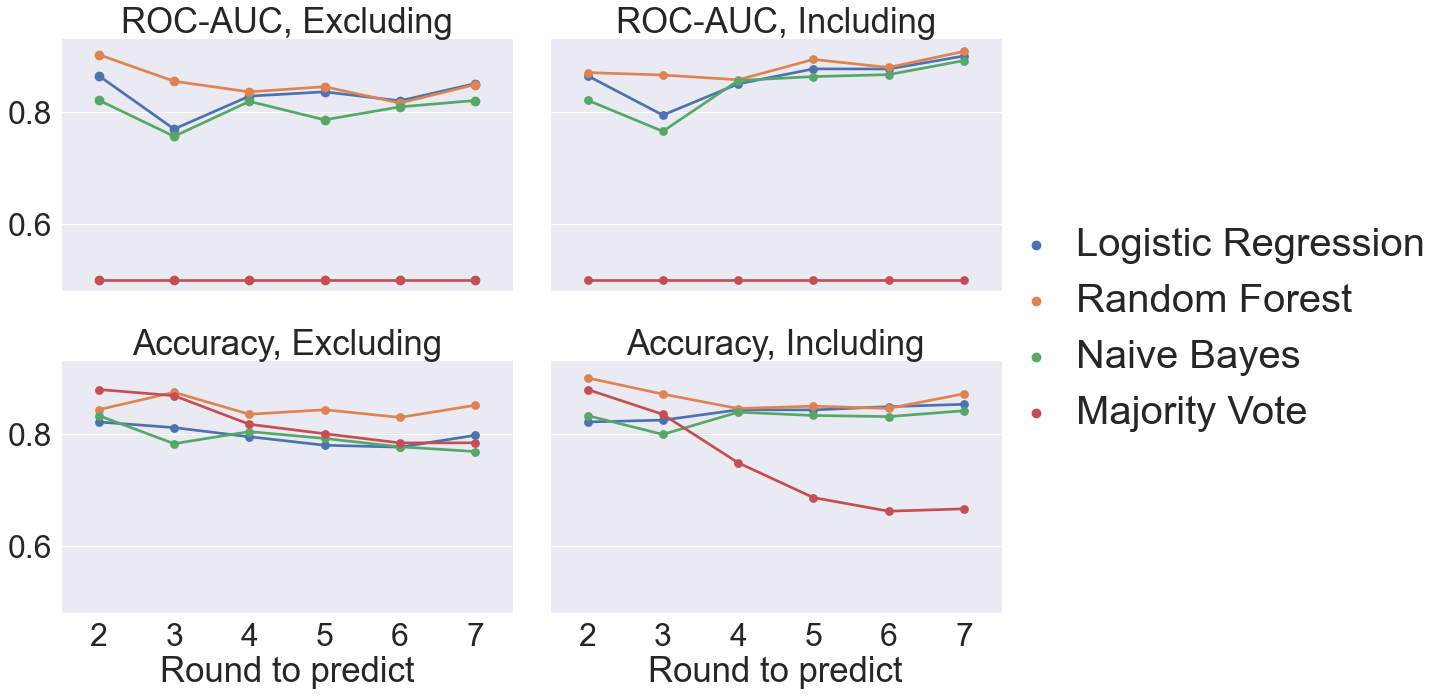

In [6]:
df = results.copy()

metrics = ["acc", "roc_auc",] 
metrics = ','.join([f'"{metric_map[m]}"' for m in metrics])
df = df.query(f'{Cols.metric} in ({metrics})')

sns.set(font_scale=2.9)
g = sns.catplot(data=df, row=Cols.metric, col=Cols.approach,
                 x=Cols.round_to_predict, y=Cols.score, hue=Cols.model,
                 aspect=12/8, legend=True, ci=0, kind="point")
g.set_titles(template='{row_name}, {col_name}')

handles, labels = g.axes[0][0].get_legend_handles_labels()

[ha.set_linewidth(3) for ha in handles]
g._legend.remove()

g.set_axis_labels(y_var='')

g.fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.035, .5),
             handletextpad=.001, ncol=1, frameon=False, fontsize=40)

fig_name = 'model-performance-comparison-acc-rocauc-wide'
for ext in ('.pdf', '.svg'):
    g.savefig('plots/' + fig_name + ext)
    print(f'wrote {fig_name + ext}')

## Feature importance

In [7]:
def filter_dataframe(dataframe, last_round, all_prev_round=False):
    columns = ["dataset", "round_to_predict", "features_up_to_round",
                "approach", "model", "feature_importance"]
    
    # Feature importance was only dependent on the main metric
    mask = (dataframe.metric == main_metric)
    # We only care about the most important metrics for our main model
    mask &= ((dataframe.model == "LogisticRegression") | 
             (dataframe.model == "RandomForestClassifier"))
    # Let us only evaluate the most important metrics when taking advantage 
    # of a full dataset (i.e., predicting last round using all data from previous rounds)
    mask &= (dataframe.round_to_predict == last_round)
    if all_prev_round:
        mask &= (dataframe.features_up_to_round == (last_round - 1))

    return dataframe.loc[mask][columns]

## Show that there is randomness in most important features

In [8]:
from main import get_datasets
from instances.BrowsingData import BrowsingData
from instances.SubmissionData import SubmissionData

data_instances = get_datasets(['cs1-b', 'cs1-s', 'cs0_web', 'wd'])

   last_round  round  percentage   approach                   model  \
0           6      1         0.0  Excluding  RandomForestClassifier   
1           6      2         0.0  Excluding  RandomForestClassifier   
2           6      3         0.0  Excluding  RandomForestClassifier   
3           6      4         0.0  Excluding  RandomForestClassifier   
4           6      5       100.0  Excluding  RandomForestClassifier   
5           6      1         0.0  Including  RandomForestClassifier   
6           6      2         0.0  Including  RandomForestClassifier   
7           6      3         0.0  Including  RandomForestClassifier   
8           6      4         0.0  Including  RandomForestClassifier   
9           6      5       100.0  Including  RandomForestClassifier   

               dataset  
0  cs1-s  
1  cs1-s  
2  cs1-s  
3  cs1-s  
4  cs1-s  
5  cs1-s  
6  cs1-s  
7  cs1-s  
8  cs1-s  
9  cs1-s  
   last_round  round  percentage   approach                   model dataset
0      

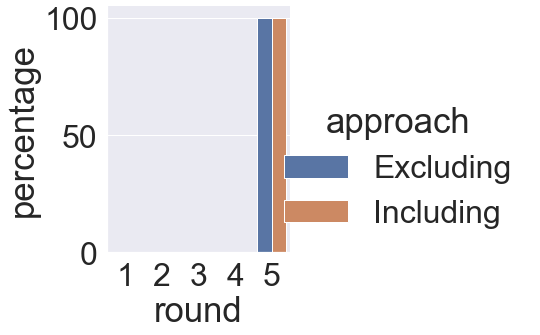

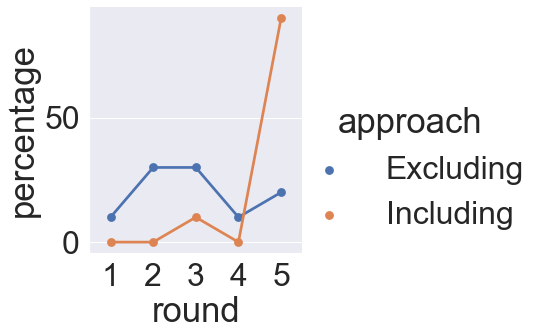

In [9]:
from collections import Counter

def show_percentage_of_previous_feature_rounds_used(dataframe, last_round,  top):

    logs = []
    
    results = filter_dataframe(dataframe, last_round, True)

    for dataset in results.dataset.unique():
        mapper = data_instances[dataset].get_features_of_each_round()
        for model in results.model.unique():
            for approach in results.approach.unique():
                df = results[(results.dataset == dataset) & 
                             (results.model == model) & 
                             (results.approach == approach)]
                
                if not df.empty:
                    d = df["feature_importance"].iloc[0]
                    if type(d) == dict:
                        d = pd.DataFrame(d)
                        d["name"] = d["name"].apply(tuple)
                                
                    importances_and_names = d.sort_values(by="importance", ascending=False)
                    features = importances_and_names.head(top)['name']
                    
                    features = [f[1] if type(f) == tuple else f for f in features]
                    features_rounds = [mapper[f] for f in features]
                    counter = Counter(features_rounds)
                    counter = {r: c/top for r, c in counter.items()}
                    
                    for r in range(1, last_round):
                        logs.append({
                            "last_round": last_round,
                            "round": r,
                            "percentage": counter.get(r, 0) * 100,
                            "approach": approach,
                            "model": model,
                            "dataset": dataset
                        })

    df = pd.DataFrame(logs)
    print(df)
    if not df.empty:
        sns.catplot(x="round", y="percentage", hue="approach", kind="point", data=df)
        sns.catplot(x="round", y="percentage", hue="approach", kind="bar", data=df)

    return df

top = 10
datasets = ["cs1-s", "wd"]
for dataset in datasets:
    df = dataframe[(dataframe.dataset == dataset) & (dataframe.model == "RandomForestClassifier")]
    show_percentage_of_previous_feature_rounds_used(df, last_round=6, top=top)

Index(['dataset', 'keep_dropped', 'features_up_to_round', 'round_to_predict',
       'model', 'metric', 'score', 'feature_importance', 'best_parameters',
       'details', 'approach'],
      dtype='object')
round 2
round 3
round 4
round 5
round 6
round 7
wrote plots/submission-feature-type-percentage-comparison.pdf
wrote plots/submission-feature-type-percentage-comparison.svg
wrote plots/submission-feature-type-percentage-comparison-distinct-datasets.pdf
wrote plots/submission-feature-type-percentage-comparison-distinct-datasets.svg
wrote plots/browsing-feature-type-percentage-comparison.pdf
wrote plots/browsing-feature-type-percentage-comparison.svg


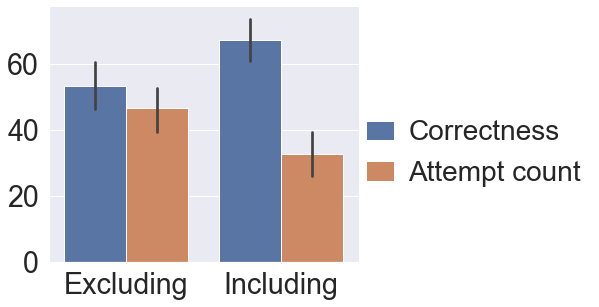

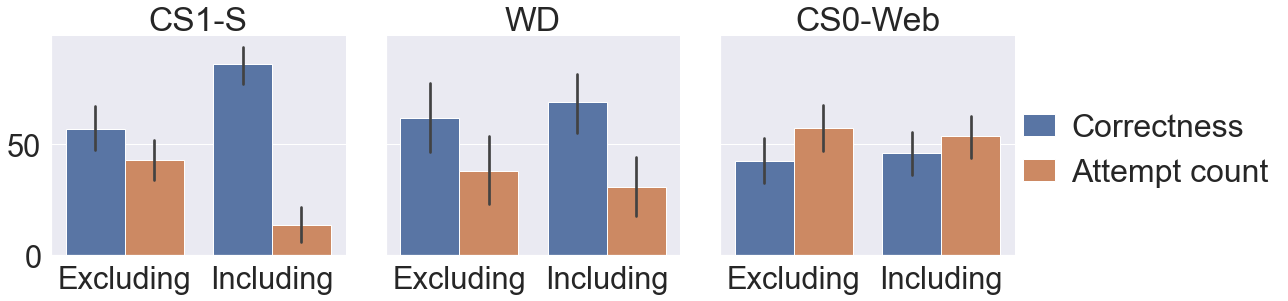

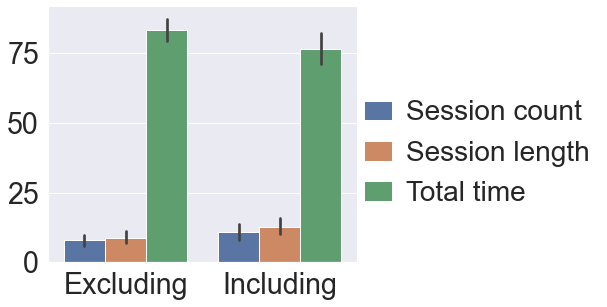

In [10]:
def feature_to_type(feature):

    """ Obtain the type of a feature given its name. """
    
    if len(feature) == 2: # submission data feature
        return feature[0]
    
    # browsing data feature
    if "count" in feature.lower():
        return "count"
    elif "length" in feature.lower():
        return "length"
    else:
        return "time"

    
def count_types(fi, top, percentage=True):
    """ Count the number of top features of each type.
    
    Parameters
    ----------
    fi: DataFrame
        Feature importance dataframe. Two columns: importance and name
    top: int, default=10
        Number of top features to take into account
    Returns
    -------
    count: DataFrame
        Count the types of the top features.
        
    """
    
    features = fi.sort_values(by="importance", ascending=False).head(top)
    features['type'] = list(map(feature_to_type, features['name']))
    count =  features.groupby('type').type.count() 
    if percentage:
        count /= len(features)
        count *= 100
    return count

def add_heights(ax, x_offset=0.015, y_offset=0.1, size=15):
    for p in ax.patches:
        ax.text(p.get_x() + x_offset, 
                p.get_height() + y_offset, 
                '{0:.2f}'.format(p.get_height()), 
                color='black', rotation='horizontal', size=size)

def save_fig(g, fig_name):
    for ext in ('.pdf', '.svg'):
        save_path = f'plots/{fig_name}{ext}' 
        g.savefig(save_path)
        print(f'wrote {save_path}')

def compare_feature_importance(dataframe, last_round=6, main_metric="pr_auc", top=10):
    """ """
    print(dataframe.columns)
    columns = ["dataset", "round_to_predict", "features_up_to_round", 
               "model", "approach", "feature_importance"]
    types = {"browsing_types": ["count", "length", "time"],
            "submissions_types": ["solved", "submission_time"]}
    logs = []
    for last_round in range(2, 8):
        results = filter_dataframe(dataframe, last_round, False)
        print('round', last_round)
        results.feature_importance = results.feature_importance.apply(pd.DataFrame)
        for _, row in results.iterrows():
            count = count_types(row['feature_importance'], top)
            if "browsing" in row['dataset']:
                feature_types = types["browsing_types"]
            else:
                feature_types = types["submissions_types"]
            for c in feature_types:
                count[c] = 0 if c not in count else count[c]

            for t, c in count.to_dict().items():
                log = {col: row[col] for col in columns[:-1]}
                log["Type"], log["Percentage"] = t, c
                logs.append(log)

    data = update_result_labels(pd.DataFrame(logs))

    type_map = {
        'solved': 'Correctness',
        'late': 'Late attempt count',
        'submission_time': 'Attempt count',
        'length': 'Session length',
        'count': 'Session count',
        'time': 'Total time'
    }

    data["Type"] = data["Type"].apply(lambda x: type_map[x] if x in type_map else x)
    sns.set(font_scale=2.6)
    if not data.empty:
        df = data.query(f'{Cols.dataset} != "{Datasets.cs1_browsing}"')

        g = sns.catplot(x=Cols.approach, y="Percentage", hue="Type", kind="bar", aspect=11/9, data=df)
        handles, labels = g.axes[0][0].get_legend_handles_labels()
        g._legend.remove()
        g.set_axis_labels(y_var='', x_var='')
        g.fig.legend(handles, labels, loc='center right', bbox_to_anchor=(.945, .5),
                    handletextpad=.5, handlelength=1, ncol=1, frameon=False, fontsize=28)

        save_fig(g, 'submission-feature-type-percentage-comparison')

        sns.set(font_scale=2.8)
        g = sns.catplot(x=Cols.approach, y="Percentage", col=Cols.dataset, hue="Type", kind="bar", data=df)
        handles, labels = g.axes[0][0].get_legend_handles_labels()
        g._legend.remove()
        g.set_axis_labels(y_var='', x_var='')
        g.fig.legend(handles, labels, loc='center right', bbox_to_anchor=(.977, .5),
                    handletextpad=.5, handlelength=1, ncol=1, frameon=False, fontsize=32)
        g.set_titles(template='{col_name}')

        save_fig(g, 'submission-feature-type-percentage-comparison-distinct-datasets')

        df = data.query(f'{Cols.dataset} == "{Datasets.cs1_browsing}"')

        sns.set(font_scale=2.6)
        g = sns.catplot(x=Cols.approach, y="Percentage", hue="Type", kind="bar", aspect=11/9, data=df)
        handles, labels = g.axes[0][0].get_legend_handles_labels()
        g._legend.remove()
        g.set_axis_labels(y_var='', x_var='')
        g.fig.legend(handles, labels, loc='center right', bbox_to_anchor=(.945, .5),
                    handletextpad=.5, handlelength=1, ncol=1, frameon=False, fontsize=28)

        save_fig(g, 'browsing-feature-type-percentage-comparison')

    return data

df = compare_feature_importance(dataframe, top=10)
